2025-07-09 14:49:10,726 - INFO - Fetching fresh data for EURUSD=X
2025-07-09 14:49:12,616 - INFO - Data cached for EURUSD=X
2025-07-09 14:49:12,617 - INFO - Fetched 2128 data points for EURUSD=X
2025-07-09 14:49:12,618 - INFO - Data acquisition: 1.9078s
2025-07-09 14:49:12,672 - INFO - Created 48 features
2025-07-09 14:49:12,673 - INFO - Feature engineering: 0.0536s
2025-07-09 14:49:13,256 - INFO - Fitting anomaly detection methods: 0.5823s
2025-07-09 14:49:13,256 - INFO - All anomaly detection methods fitted successfully
2025-07-09 14:49:13,257 - INFO - Anomaly detection setup: 0.5833s
2025-07-09 14:49:16,935 - INFO - Mahalanobis detection: 3.6758s
2025-07-09 14:49:17,925 - INFO - BCP detection: 0.9892s
C:\Users\Alireza Kamrani\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
2025-07-09 14:49:17,955 - INFO - Isolation Forest detection: 0.0290s
C:\Users\Alir


ANOMALY DETECTION SUMMARY
Mahalanobis         :   50 ( 2.42%)
Bcp                 :    0 ( 0.00%)
Isolation_forest    :  609 (29.52%)
Dbscan              : 2063 (100.00%)
Pca                 : 2063 (100.00%)
Ensemble            :  609 (29.52%)


C:\Users\Alireza Kamrani\AppData\Local\Temp\ipykernel_6592\4259212724.py:643: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent title overlap
2025-07-09 14:49:28,158 - INFO - Analysis plot saved to anomaly_analysis_EURUSD_X.jpg


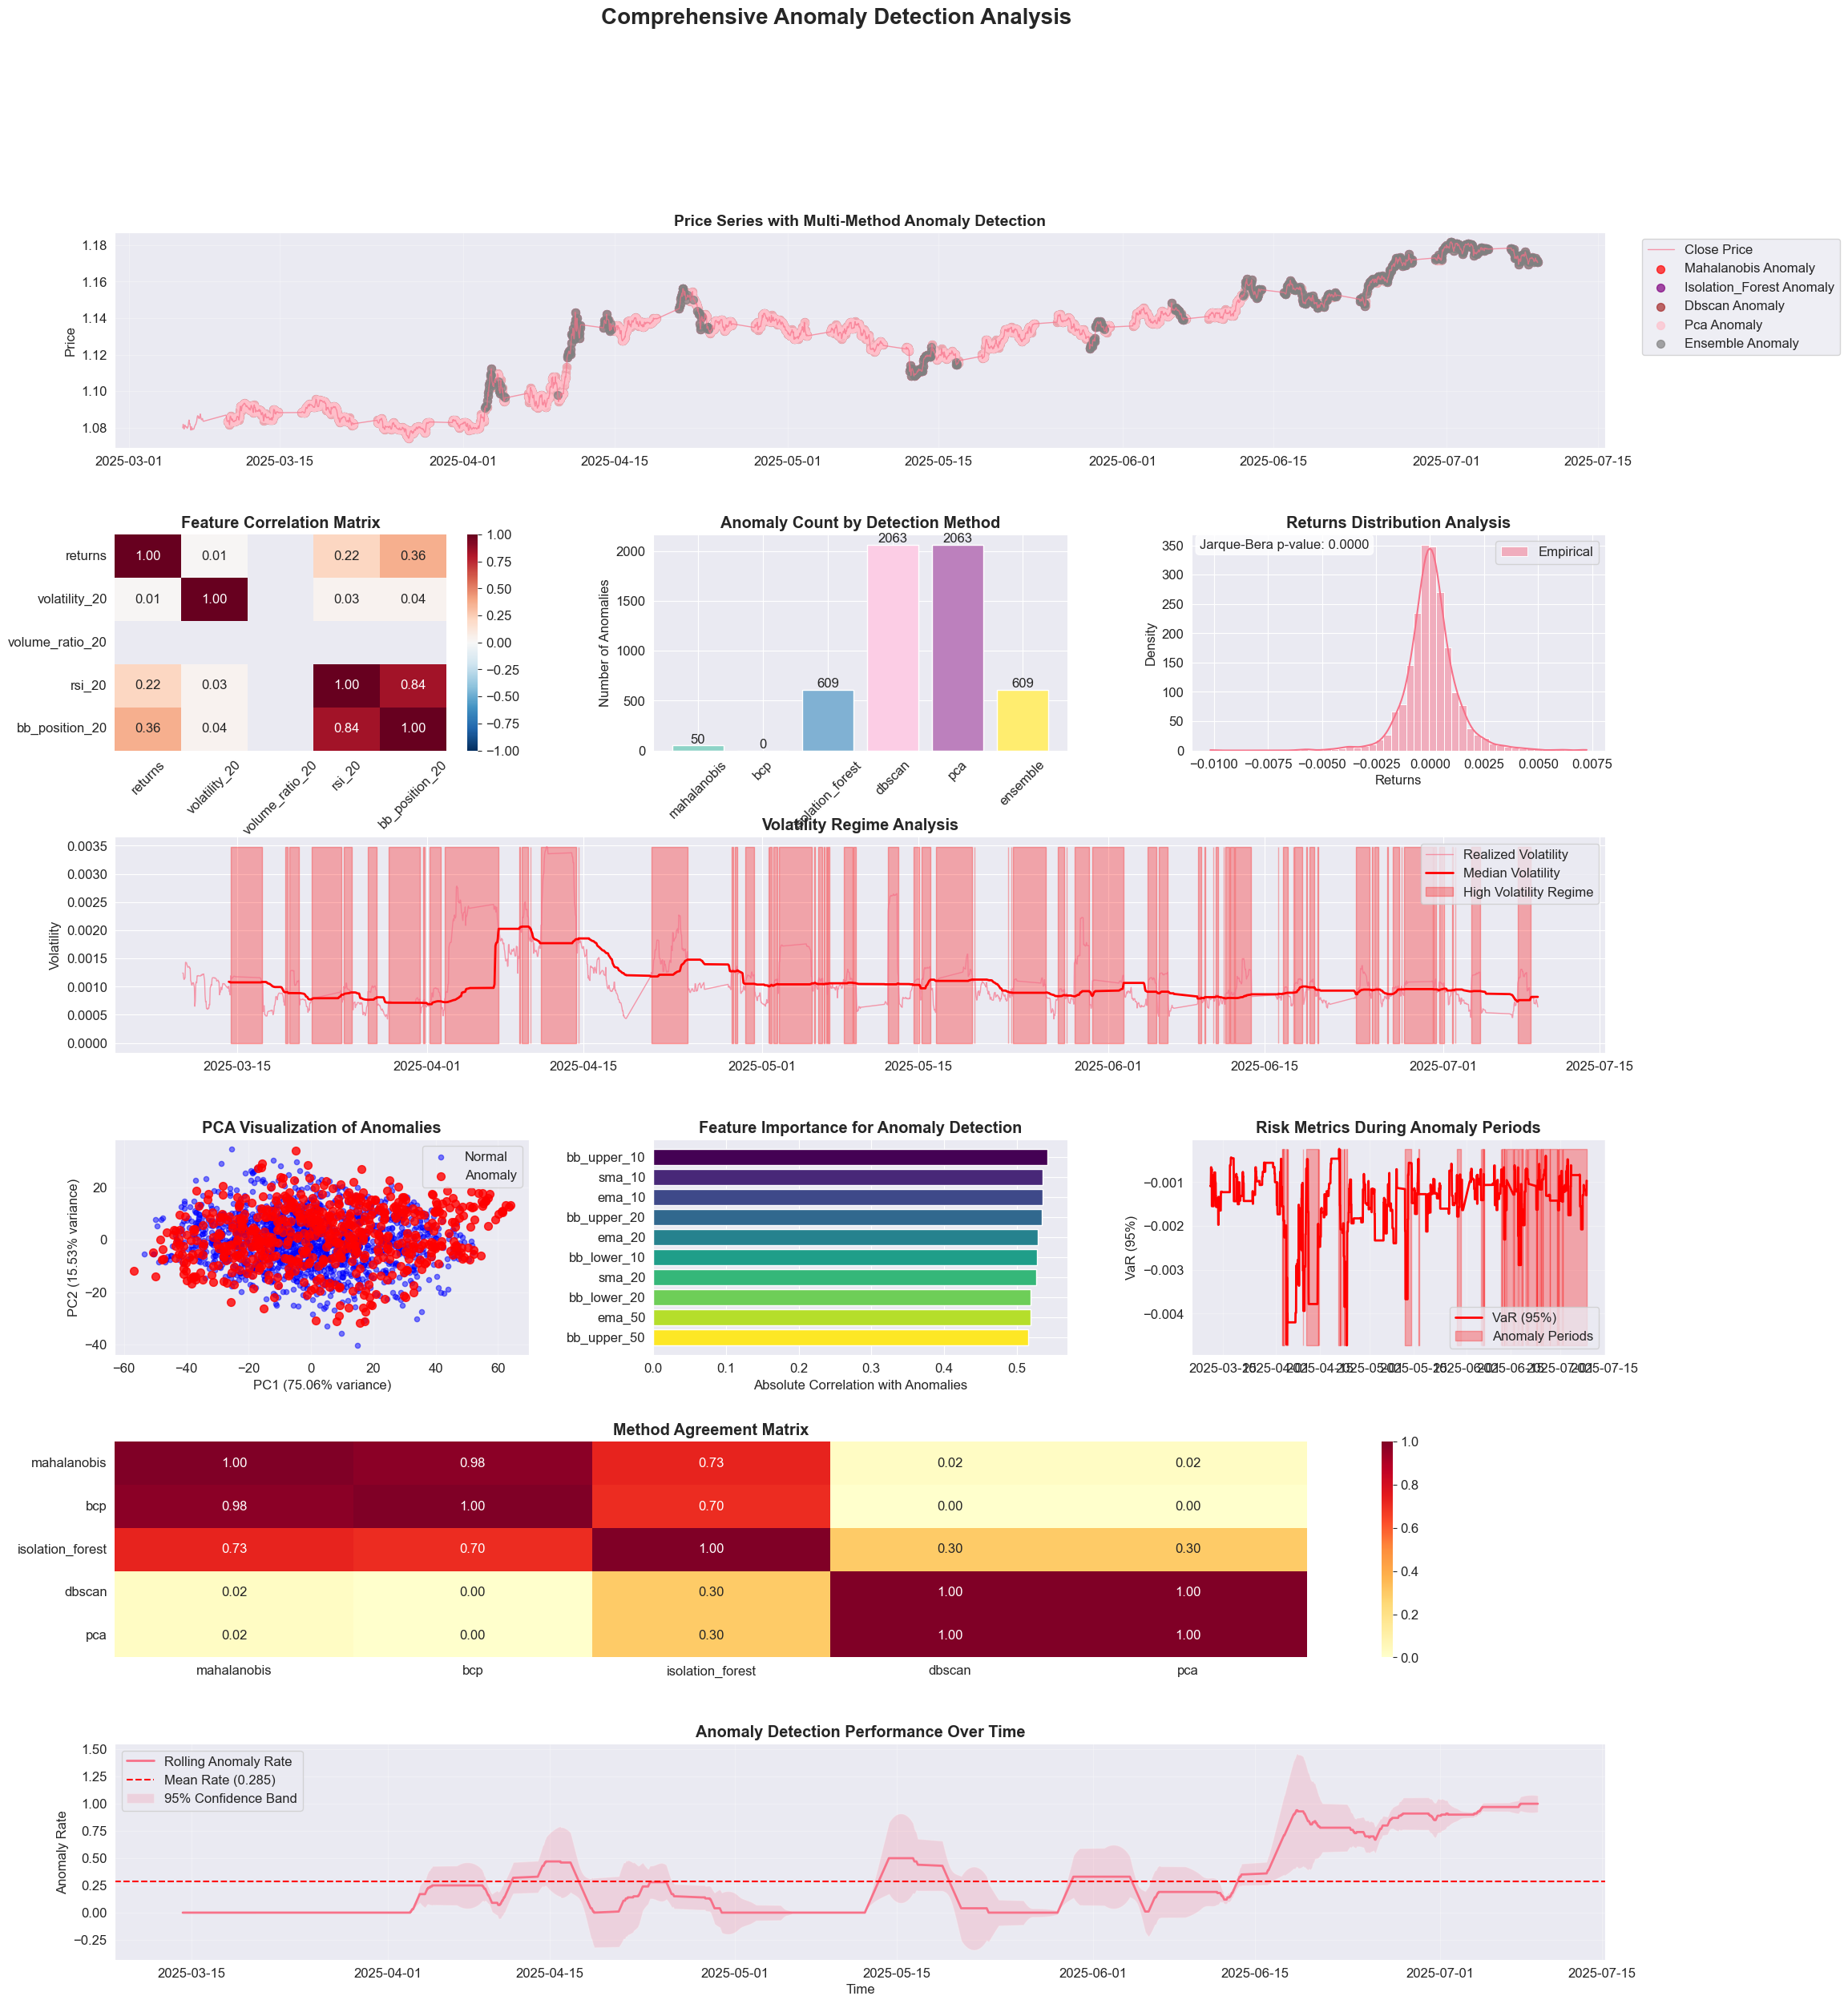

2025-07-09 14:49:31,432 - INFO - Visualization: 13.4192s
2025-07-09 14:49:31,651 - INFO - Results exported to anomaly_results_EURUSD_X.csv
2025-07-09 14:49:31,652 - INFO - Results export: 0.2058s



Detected 609 ensemble anomalies

Top 5 anomalies by timestamp:
                           mahalanobis    bcp  isolation_forest  dbscan   pca  ensemble
Datetime                                                                               
2025-04-02 23:00:00+00:00        False  False              True    True  True      True
2025-04-03 01:00:00+00:00        False  False              True    True  True      True
2025-04-03 02:00:00+00:00        False  False              True    True  True      True
2025-04-03 05:00:00+00:00        False  False              True    True  True      True
2025-04-03 06:00:00+00:00        False  False              True    True  True      True


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2, t as student_t, jarque_bera, normaltest
from scipy.special import logsumexp, gammaln
from scipy.optimize import minimize_scalar
import seaborn as sns
import yfinance as yf
from functools import partial
import warnings
from typing import Tuple, Optional, Union, Dict, List
from dataclasses import dataclass
from abc import ABC, abstractmethod
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
from contextlib import contextmanager
import time
from numba import jit, prange
from sklearn.preprocessing import RobustScaler
from sklearn.covariance import EmpiricalCovariance, LedoitWolf
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set plot style
sns.set_style("darkgrid")
sns.set_palette("husl")

@contextmanager
def timer(description: str):
    """Context manager for timing operations"""
    start = time.time()
    yield
    elapsed = time.time() - start
    logger.info(f"{description}: {elapsed:.4f}s")

@dataclass
class AnomalyConfig:
    """Configuration for anomaly detection parameters"""
    mahalanobis_threshold: float = 0.01
    bcp_threshold: float = 0.5
    isolation_forest_contamination: float = 0.1
    dbscan_eps: float = 0.3
    dbscan_min_samples: int = 5
    rolling_window_size: int = 20
    pca_components: int = 5
    use_robust_covariance: bool = True
    normalization_method: str = 'robust'  # 'robust', 'standard', 'minmax'

class NumericalStabilityMixin:
    """Mixin class for numerical stability utilities"""

    @staticmethod
    def safe_log(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
        """Numerically stable logarithm"""
        return np.log(np.maximum(x, eps))

    @staticmethod
    def safe_divide(numerator: np.ndarray, denominator: np.ndarray, eps: float = 1e-12) -> np.ndarray:
        """Numerically stable division"""
        return numerator / np.maximum(denominator, eps)

    @staticmethod
    def safe_sqrt(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
        """Numerically stable square root"""
        return np.sqrt(np.maximum(x, eps))

class AdvancedStudentT(NumericalStabilityMixin):
    """
    Advanced multivariate Student-T model with proper parameter estimation
    and numerical stability enhancements
    """

    def __init__(self, dims: int, prior_strength: float = 1.0):
        self.dims = dims
        self.prior_strength = prior_strength
        self.reset_parameters()

    def reset_parameters(self):
        """Reset all parameters to initial values"""
        self._df = 3.0  # Start with low degrees of freedom for heavy tails
        self._loc = np.zeros(self.dims)
        self._precision = np.eye(self.dims)  # Use precision matrix for stability
        self._scale_factor = 1.0
        self.n_points = 0
        self._sum_x = np.zeros(self.dims)
        self._sum_xx = np.zeros((self.dims, self.dims))

    def logpdf(self, x: np.ndarray) -> float:
        """
        Log probability density function with numerical stability
        """
        if self.n_points == 0:
            return 0.0  # Non-informative prior

        try:
            diff = x - self._loc
            quad_form = np.dot(diff, np.dot(self._precision, diff))

            # Multivariate Student-T log pdf
            log_gamma_term = (gammaln((self._df + self.dims) / 2) -
                            gammaln(self._df / 2) -
                            0.5 * self.dims * np.log(self._df * np.pi))

            log_det_term = 0.5 * np.linalg.slogdet(self._precision)[1]
            log_quad_term = -0.5 * (self._df + self.dims) * self.safe_log(1 + quad_form / self._df)

            return log_gamma_term + log_det_term + log_quad_term
        except (np.linalg.LinAlgError, ValueError):
            return -np.inf

    def update_theta(self, x: np.ndarray):
        """
        Robust online parameter update using Welford's algorithm
        """
        self.n_points += 1

        # Update sufficient statistics
        self._sum_x += x
        self._sum_xx += np.outer(x, x)

        if self.n_points == 1:
            self._loc = x.copy()
            return

        # Update location (mean)
        self._loc = self._sum_x / self.n_points

        # Update covariance matrix with regularization
        if self.n_points > self.dims + 1:
            sample_cov = (self._sum_xx / self.n_points - np.outer(self._loc, self._loc))

            # Add regularization for numerical stability
            regularization = 1e-6 * np.eye(self.dims)
            sample_cov += regularization

            # Update precision matrix
            try:
                self._precision = np.linalg.inv(sample_cov)
            except np.linalg.LinAlgError:
                # Fall back to pseudo-inverse
                self._precision = np.linalg.pinv(sample_cov)

        # Adaptive degrees of freedom estimation
        if self.n_points > 2 * self.dims:
            self._update_degrees_of_freedom()

    def _update_degrees_of_freedom(self):
        """Estimate degrees of freedom using method of moments"""
        if self.n_points < 3:
            return

        # Simple heuristic: higher kurtosis suggests lower degrees of freedom
        try:
            # Estimate from the trace of the covariance matrix
            trace_cov = np.trace(np.linalg.inv(self._precision))
            self._df = max(3.0, min(30.0, 2 * trace_cov / (trace_cov - 1) if trace_cov > 1 else 3.0))
        except:
            self._df = 5.0  # Default fallback

@jit(nopython=True, parallel=True)
def fast_mahalanobis_batch(data: np.ndarray, mean: np.ndarray, inv_cov: np.ndarray) -> np.ndarray:
    """Numba-optimized batch Mahalanobis distance calculation"""
    n_samples = data.shape[0]
    distances = np.zeros(n_samples)

    for i in prange(n_samples):
        diff = data[i] - mean
        distances[i] = np.sqrt(np.dot(diff, np.dot(inv_cov, diff)))

    return distances

class RobustBayesianChangePointDetection(NumericalStabilityMixin):
    """
    Robust Bayesian Change Point Detection with advanced numerical stability
    """

    def __init__(self, hazard_rate: float = 0.01, max_run_length: int = 1000):
        self.hazard_rate = hazard_rate
        self.max_run_length = max_run_length

    def detect_changepoints(self, data: np.ndarray, observation_model: AdvancedStudentT) -> np.ndarray:
        """
        Detect change points using numerically stable online algorithm
        """
        n_data = data.shape[0]

        # Initialize log run length probabilities
        max_rl = min(self.max_run_length, n_data)
        log_R = np.full((n_data + 1, max_rl + 1), -np.inf)
        log_R[0, 0] = 0.0

        cp_probs = np.zeros(n_data)

        for t in range(n_data):
            x = data[t]

            # Calculate observation likelihoods
            log_pred_probs = observation_model.logpdf(x)

            # Truncate run lengths for computational efficiency
            active_run_lengths = min(t + 1, max_rl)

            # Hazard and survival probabilities
            run_lengths = np.arange(1, active_run_lengths + 1)
            hazard_probs = self.hazard_rate / (1 + self.hazard_rate * run_lengths)
            survival_probs = 1 - hazard_probs

            log_hazard = self.safe_log(hazard_probs)
            log_survival = self.safe_log(survival_probs)

            # Growth probabilities (no change point)
            log_growth_probs = (log_R[t, :active_run_lengths] +
                              log_pred_probs +
                              log_survival)

            # Change point probability
            log_cp_prob = logsumexp(log_R[t, :active_run_lengths] +
                                   log_pred_probs +
                                   log_hazard)

            # Evidence (normalization)
            log_evidence = logsumexp(np.append(log_growth_probs, log_cp_prob))

            # Update run length probabilities
            if active_run_lengths > 0:
                log_R[t+1, 1:active_run_lengths+1] = log_growth_probs - log_evidence
            log_R[t+1, 0] = log_cp_prob - log_evidence

            # Store change point probability
            cp_probs[t] = np.exp(log_cp_prob - log_evidence)

            # Update observation model
            observation_model.update_theta(x)

        return cp_probs

class AdvancedFeatureEngineer:
    """
    Advanced feature engineering with technical indicators and market microstructure features
    """

    def __init__(self, window_sizes: List[int] = [10, 20, 50]):
        self.window_sizes = window_sizes
        self.scaler = RobustScaler()
        self.pca = PCA(n_components=5)
        self.fitted = False

    def create_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Create comprehensive feature set"""
        features = pd.DataFrame(index=data.index)

        # Basic price features using original case columns
        features['returns'] = np.log(data['Close'] / data['Close'].shift(1))
        # This feature is safe because log(0 + 1) is 0
        features['log_volume'] = np.log(data['Volume'] + 1)
        features['price_range'] = (data['High'] - data['Low']) / data['Close']
        features['price_position'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])

        # Technical indicators
        self._add_technical_indicators(features, data)

        # Market microstructure features
        self._add_microstructure_features(features, data)

        # Higher-order moments
        self._add_higher_moments(features, data)

        # Regime features
        self._add_regime_features(features, data)

        return features

    def _add_technical_indicators(self, features: pd.DataFrame, data: pd.DataFrame):
        """Add technical analysis indicators"""
        for window in self.window_sizes:
            features[f'sma_{window}'] = data['Close'].rolling(window).mean()
            features[f'ema_{window}'] = data['Close'].ewm(span=window).mean()
            features[f'volatility_{window}'] = features['returns'].rolling(window).std()
            features[f'parkinson_{window}'] = np.sqrt(
                np.log(data['High'] / data['Low']).rolling(window).mean() / (4 * np.log(2))
            )
            sma = features[f'sma_{window}']
            std = features['returns'].rolling(window).std()
            features[f'bb_upper_{window}'] = sma + 2 * std
            features[f'bb_lower_{window}'] = sma - 2 * std
            features[f'bb_position_{window}'] = (data['Close'] - features[f'bb_lower_{window}']) / (
                features[f'bb_upper_{window}'] - features[f'bb_lower_{window}']
            )
            delta = data['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
            # Handle potential division by zero in RSI
            rs = gain / loss.replace(0, 1e-12)
            features[f'rsi_{window}'] = 100 - (100 / (1 + rs))

    def _add_microstructure_features(self, features: pd.DataFrame, data: pd.DataFrame):
        """Add market microstructure features"""

        # This feature does not depend on volume being non-zero
        features['spread_proxy'] = (data['High'] - data['Low']) / data['Close']

        # --- Robust check for volume data ---
        if data['Volume'].sum() > 0:
            features['vwap'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
            features['ofi'] = (data['Close'] - data['Open']) * data['Volume']
            for window in [10, 20]:
                # Use a small epsilon to prevent division by zero
                rolling_mean_vol = data['Volume'].rolling(window).mean().replace(0, 1e-12)
                features[f'volume_ratio_{window}'] = data['Volume'] / rolling_mean_vol
                features[f'volume_volatility_{window}'] = data['Volume'].rolling(window).std()
        else:
            # If volume is all zero, set these features to 0
            features['vwap'] = 0
            features['ofi'] = 0
            for window in [10, 20]:
                features[f'volume_ratio_{window}'] = 0
                features[f'volume_volatility_{window}'] = 0

    def _add_higher_moments(self, features: pd.DataFrame, data: pd.DataFrame):
        """Add higher-order statistical moments"""
        for window in [20, 50]:
            returns = features['returns']
            features[f'skewness_{window}'] = returns.rolling(window).skew()
            features[f'kurtosis_{window}'] = returns.rolling(window).kurt()
            features[f'realized_var_{window}'] = returns.rolling(window).var()
            features[f'realized_skew_{window}'] = (returns**3).rolling(window).mean()
            features[f'realized_kurt_{window}'] = (returns**4).rolling(window).mean()

    def _add_regime_features(self, features: pd.DataFrame, data: pd.DataFrame):
        """Add regime-dependent features"""
        # Volatility regime
        vol_20 = features['returns'].rolling(20).std()
        vol_median = vol_20.rolling(100).median()
        features['vol_regime'] = (vol_20 > vol_median).astype(int)

        # Trend regime
        price_20 = data['Close'].rolling(20).mean()
        price_50 = data['Close'].rolling(50).mean()
        features['trend_regime'] = (price_20 > price_50).astype(int)

        # --- Robust check for volume regime ---
        if data['Volume'].sum() > 0:
            vol_20_mean = data['Volume'].rolling(20).mean()
            vol_median_vol = vol_20_mean.rolling(100).median()
            features['volume_regime'] = (vol_20_mean > vol_median_vol).astype(int)
        else:
            # If volume is zero, regime is zero
            features['volume_regime'] = 0

class MultiMethodAnomalyDetector:
    """
    Advanced anomaly detection using multiple complementary methods
    """

    def __init__(self, config: AnomalyConfig):
        self.config = config
        self.methods = {}
        self.feature_importance = {}
        self.is_fitted = False

    def fit(self, features: pd.DataFrame, training_size: int):
        """Fit all detection methods"""
        training_data = features.iloc[:training_size]

        with timer("Fitting anomaly detection methods"):
            # Mahalanobis distance
            self._fit_mahalanobis(training_data)

            # Bayesian Change Point Detection
            self._fit_bcp(training_data)

            # Isolation Forest
            self._fit_isolation_forest(training_data)

            # DBSCAN clustering
            self._fit_dbscan(training_data)

            # PCA-based detection
            self._fit_pca_anomaly(training_data)

        self.is_fitted = True
        logger.info("All anomaly detection methods fitted successfully")

    def _fit_mahalanobis(self, data: pd.DataFrame):
        """Fit Mahalanobis distance method"""
        if self.config.use_robust_covariance:
            cov_estimator = LedoitWolf()
        else:
            cov_estimator = EmpiricalCovariance()

        cov_estimator.fit(data)
        self.methods['mahalanobis'] = {
            'mean': data.mean().values,
            'inv_cov': cov_estimator.precision_,
            'cov': cov_estimator.covariance_
        }

    def _fit_bcp(self, data: pd.DataFrame):
        """Fit Bayesian Change Point Detection"""
        # Select subset of features for BCP to avoid curse of dimensionality
        key_features = ['returns', 'volatility_20', 'volume_ratio_20', 'rsi_20']
        available_features = [f for f in key_features if f in data.columns]

        if not available_features:
            available_features = data.columns[:min(5, len(data.columns))].tolist()

        bcp_data = data[available_features].values

        self.methods['bcp'] = {
            'detector': RobustBayesianChangePointDetection(),
            'model': AdvancedStudentT(len(available_features)),
            'feature_columns': available_features
        }

    def _fit_isolation_forest(self, data: pd.DataFrame):
        """Fit Isolation Forest"""
        iso_forest = IsolationForest(
            contamination=self.config.isolation_forest_contamination,
            random_state=42,
            n_estimators=100
        )
        iso_forest.fit(data)
        self.methods['isolation_forest'] = iso_forest

    def _fit_dbscan(self, data: pd.DataFrame):
        """Fit DBSCAN clustering"""
        # Normalize data for DBSCAN
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(data)

        dbscan = DBSCAN(
            eps=self.config.dbscan_eps,
            min_samples=self.config.dbscan_min_samples
        )
        dbscan.fit(scaled_data)

        self.methods['dbscan'] = {
            'model': dbscan,
            'scaler': scaler,
            'n_clusters': len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        }

    def _fit_pca_anomaly(self, data: pd.DataFrame):
        """Fit PCA-based anomaly detection"""
        pca = PCA(n_components=min(self.config.pca_components, data.shape[1]))
        transformed = pca.fit_transform(data)

        # Reconstruction error threshold
        reconstructed = pca.inverse_transform(transformed)
        reconstruction_errors = np.mean((data.values - reconstructed)**2, axis=1)
        threshold = np.percentile(reconstruction_errors, 95)

        self.methods['pca'] = {
            'model': pca,
            'threshold': threshold,
            'scaler': RobustScaler().fit(data)
        }

    def detect_anomalies(self, features: pd.DataFrame) -> pd.DataFrame:
        """Detect anomalies using all methods"""
        if not self.is_fitted:
            raise ValueError("Detector must be fitted before detecting anomalies")

        results = pd.DataFrame(index=features.index)

        # Mahalanobis distance
        with timer("Mahalanobis detection"):
            results['mahalanobis'] = self._detect_mahalanobis(features)

        # Bayesian Change Point Detection
        with timer("BCP detection"):
            results['bcp'] = self._detect_bcp(features)

        # Isolation Forest
        with timer("Isolation Forest detection"):
            results['isolation_forest'] = self._detect_isolation_forest(features)

        # DBSCAN
        with timer("DBSCAN detection"):
            results['dbscan'] = self._detect_dbscan(features)

        # PCA
        with timer("PCA detection"):
            results['pca'] = self._detect_pca(features)

        # Ensemble method
        results['ensemble'] = self._ensemble_method(results)

        return results

    def _detect_mahalanobis(self, features: pd.DataFrame) -> pd.Series:
        """Detect anomalies using Mahalanobis distance"""
        mean = self.methods['mahalanobis']['mean']
        inv_cov = self.methods['mahalanobis']['inv_cov']

        distances = fast_mahalanobis_batch(features.values, mean, inv_cov)
        p_values = 1 - chi2.cdf(distances**2, df=features.shape[1])

        return pd.Series(p_values < self.config.mahalanobis_threshold,
                        index=features.index, name='mahalanobis_anomaly')

    def _detect_bcp(self, features: pd.DataFrame) -> pd.Series:
        """Detect anomalies using Bayesian Change Point Detection"""
        bcp_method = self.methods['bcp']
        feature_cols = bcp_method['feature_columns']

        # Select only the features used during training
        available_cols = [col for col in feature_cols if col in features.columns]
        if not available_cols:
            return pd.Series(False, index=features.index, name='bcp_anomaly')

        bcp_data = features[available_cols].values

        # Reset model for new detection
        model = AdvancedStudentT(len(available_cols))
        cp_probs = bcp_method['detector'].detect_changepoints(bcp_data, model)

        return pd.Series(cp_probs > self.config.bcp_threshold,
                        index=features.index, name='bcp_anomaly')

    def _detect_isolation_forest(self, features: pd.DataFrame) -> pd.Series:
        """Detect anomalies using Isolation Forest"""
        iso_forest = self.methods['isolation_forest']
        predictions = iso_forest.predict(features.values)

        return pd.Series(predictions == -1, index=features.index, name='isolation_forest_anomaly')

    def _detect_dbscan(self, features: pd.DataFrame) -> pd.Series:
        """Detect anomalies using DBSCAN"""
        dbscan_method = self.methods['dbscan']
        scaler = dbscan_method['scaler']

        scaled_data = scaler.transform(features.values)
        predictions = dbscan_method['model'].fit_predict(scaled_data)

        return pd.Series(predictions == -1, index=features.index, name='dbscan_anomaly')

    def _detect_pca(self, features: pd.DataFrame) -> pd.Series:
        """Detect anomalies using PCA reconstruction error"""
        pca_method = self.methods['pca']
        pca_model = pca_method['model']
        scaler = pca_method['scaler']
        threshold = pca_method['threshold']

        scaled_data = scaler.transform(features.values)
        transformed = pca_model.transform(scaled_data)
        reconstructed = pca_model.inverse_transform(transformed)

        reconstruction_errors = np.mean((scaled_data - reconstructed)**2, axis=1)

        return pd.Series(reconstruction_errors > threshold,
                        index=features.index, name='pca_anomaly')

    def _ensemble_method(self, results: pd.DataFrame) -> pd.Series:
        """Combine multiple methods using ensemble approach"""
        # Weighted voting (you can adjust weights based on method performance)
        weights = {
            'mahalanobis': 0.3,
            'bcp': 0.25,
            'isolation_forest': 0.2,
            'dbscan': 0.15,
            'pca': 0.1
        }

        ensemble_score = np.zeros(len(results))

        for method, weight in weights.items():
            if method in results.columns:
                ensemble_score += weight * results[method].astype(float)

        # Threshold for ensemble decision
        ensemble_threshold = 0.4

        return pd.Series(ensemble_score > ensemble_threshold,
                        index=results.index, name='ensemble_anomaly')

class AdvancedVisualization:
    """
    Advanced visualization with interactive plots and statistical analysis
    """

    def __init__(self, figsize: Tuple[int, int] = (20, 24)):
        self.figsize = figsize
        plt.rcParams['figure.figsize'] = figsize
        plt.rcParams['font.size'] = 12

    def plot_comprehensive_analysis(self, data: pd.DataFrame, features: pd.DataFrame,
                                  anomaly_results: pd.DataFrame, config: AnomalyConfig,
                                  output_filename: str = "anomaly_analysis.jpg"):
        """Create comprehensive analysis visualization and save it to a file."""

        fig = plt.figure(figsize=self.figsize)
        gs = fig.add_gridspec(6, 3, hspace=0.4, wspace=0.3)

        # 1. Price and Volume with Anomalies
        ax1 = fig.add_subplot(gs[0, :])
        self._plot_price_anomalies(ax1, data, anomaly_results)

        # 2. Feature Correlation Heatmap
        ax2 = fig.add_subplot(gs[1, 0])
        self._plot_feature_correlation(ax2, features)

        # 3. Anomaly Method Comparison
        ax3 = fig.add_subplot(gs[1, 1])
        self._plot_anomaly_comparison(ax3, anomaly_results)

        # 4. Distribution Analysis
        ax4 = fig.add_subplot(gs[1, 2])
        self._plot_distribution_analysis(ax4, features)

        # 5. Volatility Regime
        ax5 = fig.add_subplot(gs[2, :])
        self._plot_volatility_regime(ax5, data, features)

        # 6. Anomaly Clustering
        ax6 = fig.add_subplot(gs[3, 0])
        self._plot_anomaly_clustering(ax6, features, anomaly_results)

        # 7. Feature Importance
        ax7 = fig.add_subplot(gs[3, 1])
        self._plot_feature_importance(ax7, features, anomaly_results)

        # 8. Risk Metrics
        ax8 = fig.add_subplot(gs[3, 2])
        self._plot_risk_metrics(ax8, data, features, anomaly_results)

        # 9. Ensemble Analysis
        ax9 = fig.add_subplot(gs[4, :])
        self._plot_ensemble_analysis(ax9, anomaly_results)

        # 10. Performance Metrics
        ax10 = fig.add_subplot(gs[5, :])
        self._plot_performance_metrics(ax10, data, anomaly_results)

        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent title overlap
        fig.suptitle('Comprehensive Anomaly Detection Analysis', fontsize=20, fontweight='bold')
        
        # --- MODIFICATION: Save the figure ---
        try:
            plt.savefig(output_filename, format='jpeg', dpi=300, bbox_inches='tight')
            logger.info(f"Analysis plot saved to {output_filename}")
        except Exception as e:
            logger.error(f"Failed to save plot to {output_filename}: {e}")
        
        plt.show()

    def _plot_price_anomalies(self, ax, data: pd.DataFrame, anomaly_results: pd.DataFrame):
        """Plot price with detected anomalies"""
        ax.plot(data.index, data['Close'], label='Close Price', alpha=0.7, linewidth=1)

        # Plot different types of anomalies
        colors = ['red', 'orange', 'purple', 'brown', 'pink', 'gray']
        methods = ['mahalanobis', 'bcp', 'isolation_forest', 'dbscan', 'pca', 'ensemble']

        for i, method in enumerate(methods):
            if method in anomaly_results.columns:
                anomalies = anomaly_results[anomaly_results[method]]
                if not anomalies.empty:
                    ax.scatter(anomalies.index, data.loc[anomalies.index, 'Close'],
                             c=colors[i], s=50, alpha=0.7, label=f'{method.title()} Anomaly')

        ax.set_title('Price Series with Multi-Method Anomaly Detection', fontsize=14, fontweight='bold')
        ax.set_ylabel('Price')
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    def _plot_feature_correlation(self, ax, features: pd.DataFrame):
        """Plot feature correlation heatmap"""
        key_features = ['returns', 'volatility_20', 'volume_ratio_20', 'rsi_20', 'bb_position_20']
        available_features = [f for f in key_features if f in features.columns]

        if len(available_features) < 2:
            available_features = features.columns[:min(8, len(features.columns))].tolist()

        corr_matrix = features[available_features].corr()
        sns.heatmap(corr_matrix, ax=ax, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, fmt='.2f')
        ax.set_title('Feature Correlation Matrix', fontweight='bold')
        ax.tick_params(axis='x', rotation=45)

    def _plot_anomaly_comparison(self, ax, anomaly_results: pd.DataFrame):
        """Compare anomaly detection methods"""
        methods = ['mahalanobis', 'bcp', 'isolation_forest', 'dbscan', 'pca', 'ensemble']
        available_methods = [m for m in methods if m in anomaly_results.columns]

        anomaly_counts = [anomaly_results[method].sum() for method in available_methods]

        bars = ax.bar(available_methods, anomaly_counts, color=plt.cm.Set3(np.linspace(0, 1, len(available_methods))))
        ax.set_title('Anomaly Count by Detection Method', fontweight='bold')
        ax.set_ylabel('Number of Anomalies')
        ax.tick_params(axis='x', rotation=45)

        for bar, count in zip(bars, anomaly_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(count)}', ha='center', va='bottom')

    def _plot_distribution_analysis(self, ax, features: pd.DataFrame):
        """Plot distribution analysis of key features"""
        if 'returns' in features.columns:
            returns = features['returns'].dropna()
            sns.histplot(returns, bins=50, kde=True, ax=ax, label='Empirical')

            # Statistical tests
            jb_stat, jb_p = jarque_bera(returns)
            ax.text(0.02, 0.98, f'Jarque-Bera p-value: {jb_p:.4f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            ax.set_title('Returns Distribution Analysis', fontweight='bold')
            ax.set_xlabel('Returns')
            ax.set_ylabel('Density')
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'Returns data not available',
                   ha='center', va='center', transform=ax.transAxes)

    def _plot_volatility_regime(self, ax, data: pd.DataFrame, features: pd.DataFrame):
        """Plot volatility regimes"""
        if 'volatility_20' in features.columns:
            vol = features['volatility_20'].dropna()
            vol_median = vol.rolling(100).median()

            ax.plot(vol.index, vol, label='Realized Volatility', alpha=0.7, linewidth=1)
            ax.plot(vol_median.index, vol_median, label='Median Volatility',
                   color='red', linewidth=2)

            high_vol = vol > vol_median
            ax.fill_between(vol.index, 0, vol.max(), where=high_vol,
                           alpha=0.3, color='red', label='High Volatility Regime')

            ax.set_title('Volatility Regime Analysis', fontweight='bold')
            ax.set_ylabel('Volatility')
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'Volatility data not available',
                   ha='center', va='center', transform=ax.transAxes)

    def _plot_anomaly_clustering(self, ax, features: pd.DataFrame, anomaly_results: pd.DataFrame):
        """Plot PCA visualization of anomalies"""
        try:
            feature_subset = features.select_dtypes(include=[np.number]).dropna()
            if feature_subset.shape[1] < 2:
                ax.text(0.5, 0.5, 'Insufficient features for PCA',
                       ha='center', va='center', transform=ax.transAxes)
                return

            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(feature_subset)

            # Align anomaly results with the feature subset
            aligned_anomalies = anomaly_results.loc[feature_subset.index]

            normal_mask = ~aligned_anomalies['ensemble']
            ax.scatter(pca_result[normal_mask, 0], pca_result[normal_mask, 1],
                      c='blue', alpha=0.5, s=20, label='Normal')

            anomaly_mask = aligned_anomalies['ensemble']
            if anomaly_mask.sum() > 0:
                ax.scatter(pca_result[anomaly_mask, 0], pca_result[anomaly_mask, 1],
                          c='red', alpha=0.8, s=50, label='Anomaly')

            ax.set_title('PCA Visualization of Anomalies', fontweight='bold')
            ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        except Exception as e:
            ax.text(0.5, 0.5, f'PCA visualization failed: {str(e)}',
                   ha='center', va='center', transform=ax.transAxes)

    def _plot_feature_importance(self, ax, features: pd.DataFrame, anomaly_results: pd.DataFrame):
        """Plot feature importance for anomaly detection"""
        if 'ensemble' in anomaly_results.columns:
            # Align data before calculating correlation
            aligned_features, aligned_anomalies = features.align(anomaly_results['ensemble'], join='inner', axis=0)
            
            numeric_features = aligned_features.select_dtypes(include=[np.number])
            correlations = {}

            for col in numeric_features.columns:
                try:
                    corr = np.corrcoef(numeric_features[col].fillna(0), aligned_anomalies.astype(int))[0, 1]
                    correlations[col] = abs(corr) if not np.isnan(corr) else 0
                except:
                    correlations[col] = 0

            sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:10]

            if sorted_features:
                features_names, importance_scores = zip(*sorted_features)
                y_pos = np.arange(len(features_names))
                ax.barh(y_pos, importance_scores, align='center', color=plt.cm.viridis(np.linspace(0, 1, len(features_names))))
                ax.set_yticks(y_pos)
                ax.set_yticklabels(features_names)
                ax.invert_yaxis()
                ax.set_xlabel('Absolute Correlation with Anomalies')
                ax.set_title('Feature Importance for Anomaly Detection', fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'No feature importance data', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'Ensemble results not available', ha='center', va='center', transform=ax.transAxes)

    def _plot_risk_metrics(self, ax, data: pd.DataFrame, features: pd.DataFrame, anomaly_results: pd.DataFrame):
        """Plot risk metrics during anomaly periods"""
        if 'returns' in features.columns and 'ensemble' in anomaly_results.columns:
            returns = features['returns'].dropna()
            
            # Align data
            aligned_returns, aligned_anomalies = returns.align(anomaly_results['ensemble'], join='inner', axis=0)
            
            var_95 = aligned_returns.rolling(20).quantile(0.05)
            ax.plot(var_95.index, var_95, label='VaR (95%)', linewidth=2, color='red')
            
            anomaly_periods = aligned_anomalies
            ax.fill_between(var_95.index, var_95.min(), var_95.max(),
                           where=anomaly_periods, alpha=0.3, color='red',
                           label='Anomaly Periods')

            ax.set_title('Risk Metrics During Anomaly Periods', fontweight='bold')
            ax.set_ylabel('VaR (95%)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Risk metrics data not available', ha='center', va='center', transform=ax.transAxes)

    def _plot_ensemble_analysis(self, ax, anomaly_results: pd.DataFrame):
        """Plot ensemble method analysis"""
        methods = ['mahalanobis', 'bcp', 'isolation_forest', 'dbscan', 'pca']
        available_methods = [m for m in methods if m in anomaly_results.columns]

        if len(available_methods) > 1:
            agreement_matrix = pd.DataFrame(index=available_methods, columns=available_methods, dtype=float)
            for method1 in available_methods:
                for method2 in available_methods:
                    agreement = (anomaly_results[method1] == anomaly_results[method2]).mean()
                    agreement_matrix.loc[method1, method2] = agreement

            sns.heatmap(agreement_matrix, ax=ax, annot=True, cmap='YlOrRd', vmin=0, vmax=1, fmt='.2f')
            ax.set_title('Method Agreement Matrix', fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'Insufficient methods for agreement analysis', ha='center', va='center', transform=ax.transAxes)

    def _plot_performance_metrics(self, ax, data: pd.DataFrame, anomaly_results: pd.DataFrame):
        """Plot performance metrics over time"""
        if 'ensemble' in anomaly_results.columns:
            window = 100
            anomaly_rate = anomaly_results['ensemble'].rolling(window).mean()

            ax.plot(anomaly_rate.index, anomaly_rate, label='Rolling Anomaly Rate', linewidth=2)
            ax.axhline(y=anomaly_rate.mean(), color='red', linestyle='--',
                      label=f'Mean Rate ({anomaly_rate.mean():.3f})')
            
            std_rate = anomaly_rate.rolling(window).std()
            ax.fill_between(anomaly_rate.index,
                           anomaly_rate - 2*std_rate,
                           anomaly_rate + 2*std_rate,
                           alpha=0.2, label='95% Confidence Band')

            ax.set_title('Anomaly Detection Performance Over Time', fontweight='bold')
            ax.set_ylabel('Anomaly Rate')
            ax.set_xlabel('Time')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Performance metrics not available', ha='center', va='center', transform=ax.transAxes)

class DataManager:
    """Enhanced data management with caching and validation"""

    def __init__(self, cache_dir: str = "./data_cache"):
        self.cache_dir = cache_dir
        self.setup_cache()

    def setup_cache(self):
        """Setup data caching directory"""
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)

    def fetch_data(self, ticker: str, period: str = "60d", interval: str = "30m") -> pd.DataFrame:
        """Fetch data with caching and validation"""
        cache_file = f"{self.cache_dir}/{ticker}_{period}_{interval}.pkl"

        try:
            if os.path.exists(cache_file):
                cached_data = pd.read_pickle(cache_file)
                if self._is_cache_valid(cached_data):
                    logger.info(f"Loading cached data for {ticker}")
                    return cached_data
        except Exception as e:
            logger.warning(f"Cache load failed: {e}")

        logger.info(f"Fetching fresh data for {ticker}")
        try:
            data = yf.download(ticker, period=period, interval=interval,
                             progress=False, auto_adjust=False)

            if data.empty:
                raise ValueError(f"No data found for ticker {ticker}")

            data = self._clean_data(data)

            try:
                data.to_pickle(cache_file)
                logger.info(f"Data cached for {ticker}")
            except Exception as e:
                logger.warning(f"Cache save failed: {e}")

            return data

        except Exception as e:
            logger.error(f"Data fetch failed for {ticker}: {e}")
            raise

    def _is_cache_valid(self, data: pd.DataFrame, max_age_hours: int = 1) -> bool:
        """Check if cached data is still valid"""
        if data.empty:
            return False

        last_timestamp = data.index[-1]
        current_time = pd.Timestamp.now(tz=last_timestamp.tz)
        age_hours = (current_time - last_timestamp).total_seconds() / 3600

        return age_hours < max_age_hours

    def _clean_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """Clean and validate data"""
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)

        required_ohlc_cols = ['Open', 'High', 'Low', 'Close']
        available_ohlc_cols = [col for col in required_ohlc_cols if col in data.columns]

        if available_ohlc_cols:
            data = data.dropna(subset=available_ohlc_cols)

        if 'Adj Close' in data.columns:
            data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

        if all(col in data.columns for col in ['High', 'Low', 'Close']):
            invalid_prices = (data['High'] < data['Low']) | (data['Close'] <= 0)
            if invalid_prices.any():
                logger.warning(f"Removing {invalid_prices.sum()} invalid price records")
                data = data[~invalid_prices]

        data = data.sort_index()
        return data

def main():
    """Main execution function with comprehensive error handling"""
    try:
        # Configuration
        config = AnomalyConfig(
            mahalanobis_threshold=0.01,
            bcp_threshold=0.3,
            isolation_forest_contamination=0.1,
            dbscan_eps=0.5,
            dbscan_min_samples=5,
            use_robust_covariance=True
        )

        # Data Management
        data_manager = DataManager()

        with timer("Data acquisition"):
            ticker = 'EURUSD=X'  # Can be changed to any valid ticker
            raw_data = data_manager.fetch_data(ticker, period='90d', interval='1h')
            logger.info(f"Fetched {len(raw_data)} data points for {ticker}")

        # Feature Engineering
        with timer("Feature engineering"):
            feature_engineer = AdvancedFeatureEngineer(window_sizes=[10, 20, 50])
            features = feature_engineer.create_features(raw_data)
            features = features.dropna()
            if features.empty:
                raise ValueError("Feature DataFrame is empty after dropping NaNs.")
            logger.info(f"Created {features.shape[1]} features")

        # Anomaly Detection
        with timer("Anomaly detection setup"):
            detector = MultiMethodAnomalyDetector(config)
            training_size = min(1000, len(features) // 2)
            detector.fit(features, training_size)

        with timer("Anomaly detection"):
            anomaly_results = detector.detect_anomalies(features)
            
            print("\n" + "="*60)
            print("ANOMALY DETECTION SUMMARY")
            print("="*60)
            
            for method in anomaly_results.columns:
                count = anomaly_results[method].sum()
                percentage = (count / len(anomaly_results)) * 100
                print(f"{method.capitalize():<20}: {count:>4d} ({percentage:5.2f}%)")
            
            print("="*60)

        # --- MODIFICATION: Prepare filenames for outputs ---
        ticker_filename_safe = ticker.replace("=", "_").replace("^", "")
        plot_filename = f'anomaly_analysis_{ticker_filename_safe}.jpg'
        csv_filename = f'anomaly_results_{ticker_filename_safe}.csv'

        # Visualization
        with timer("Visualization"):
            viz = AdvancedVisualization(figsize=(24, 28))
            # Pass the filename to the plotting function
            viz.plot_comprehensive_analysis(raw_data, features, anomaly_results, config, output_filename=plot_filename)
        
        # Export results
        with timer("Results export"):
            results_df = raw_data.join(features, how='inner').join(anomaly_results, how='inner')
            results_df.to_csv(csv_filename)
            logger.info(f"Results exported to {csv_filename}")

        # Additional analysis
        ensemble_anomalies = anomaly_results[anomaly_results['ensemble']]
        if not ensemble_anomalies.empty:
            print(f"\nDetected {len(ensemble_anomalies)} ensemble anomalies")
            print("\nTop 5 anomalies by timestamp:")
            print(ensemble_anomalies.head().to_string())
        else:
            print("\nNo ensemble anomalies detected with current thresholds")

    # --- FIX: Correctly indented except block ---
    except Exception as e:
        logger.error(f"An error occurred during execution: {e}", exc_info=True)
        # exc_info=True will log the full traceback for easier debugging

if __name__ == "__main__":
    # Set up warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    # Run main analysis
    main()